# Importing modules from sympy, math, numpy, scipy & matplotlib

In [106]:
from sympy.physics.mechanics import *
from sympy import trigsimp,symbols,lambdify, sin,cos
from sympy.physics.vector import init_vprinting
from math import radians,degrees,pi
import numpy as np
from scipy import linalg, integrate
from matplotlib import pyplot as plt
init_vprinting()

# Generalized coordinates, generalized velocities & symbolic variables

In [107]:
q1, q2 = dynamicsymbols('q1 q2')
u1, u2 = dynamicsymbols('q1 q2', 1)
m1,m2,L1,L2,g = symbols('m1 m2 L1 L2,g')

# Defining reference frames

In [108]:
N = ReferenceFrame('N')     #Inertial reference frame
A = N.orientnew('A', 'Axis', [q1, N.z]) # Frame rotating with first pendulum
B = N.orientnew('B', 'Axis', [q2, N.z]) # Frame rotating with second pendulum

# Assigning angular velocities to reference frames

In [109]:
omega_1 = u1
omega_2 = u2
A.set_ang_vel(N, omega_1 * N.z) 
B.set_ang_vel(N, omega_2 * N.z)

# Locations of point masses

In [110]:
O = Point('O') #Origin in Inertial Reference Frame
P1 = O.locatenew('P', L1 * A.x)  #Point of contact of first & 2nd pendulum
P2 = P1.locatenew('P2', L2 * B.x) #2nd pendulum

# Computing velocities of point masses

In [111]:
O.set_vel(N, 0)
P1.v2pt_theory(O,N,A)
P2.v2pt_theory(P2,N,B)
v1=P1.vel(N)
v2=P2.vel(N)

In [112]:
v1

In [113]:
v2

# Potential Energy - From lowest point datum

In [114]:
V1=m1*g*L1*(1-cos(q1))
V2=m2*g*(L1*(1-cos(q1))+L2*(1-cos(q2)))
V = V1 + V2
V

# Kinetic Energy

In [115]:
T = (1/2)*m1*dot(v1,v1) + (1/2)*m2*dot(v2,v2)
T

# Lagrangian

In [116]:
L=T-V
LM = LagrangesMethod(L, [q1, q2])

# Lagrange's equations, mass matrix anf forcing function

In [117]:
eqns = LM.form_lagranges_equations()

In [118]:
trigsimp(LM.mass_matrix)

⎡       2            2                               ⎤
⎢ 1.0⋅L₁ ⋅m₁ + 1.0⋅L₁ ⋅m₂   1.0⋅L₁⋅L₂⋅m₂⋅cos(q₁ - q₂)⎥
⎢                                                    ⎥
⎢                                        2           ⎥
⎣1.0⋅L₁⋅L₂⋅m₂⋅cos(q₁ - q₂)         1.0⋅L₂ ⋅m₂        ⎦

In [119]:
trigsimp(LM.forcing)

⎡        ⎛                     2                              ⎞⎤
⎢-1.0⋅L₁⋅⎝L₂⋅m₂⋅sin(q₁ - q₂)⋅q₂̇  + g⋅m₁⋅sin(q₁) + g⋅m₂⋅sin(q₁)⎠⎥
⎢                                                              ⎥
⎢                   ⎛                  2            ⎞          ⎥
⎣         1.0⋅L₂⋅m₂⋅⎝L₁⋅sin(q₁ - q₂)⋅q₁̇  - g⋅sin(q₂)⎠          ⎦

# State vector representation

In [120]:
mm=trigsimp(LM.mass_matrix_full)

In [121]:
ff=trigsimp(LM.forcing_full)

# Substitution for mass and length

In [122]:
mmq=mm.subs({L1:0.5,L2:0.5,m1:1,m2:1})
forcingq=ff.subs({L1:0.5,L2:0.5,m1:1,m2:1,g:10})

In [123]:
mmq

⎡1  0          0                  0        ⎤
⎢                                          ⎥
⎢0  1          0                  0        ⎥
⎢                                          ⎥
⎢0  0         0.5         0.25⋅cos(q₁ - q₂)⎥
⎢                                          ⎥
⎣0  0  0.25⋅cos(q₁ - q₂)        0.25       ⎦

In [124]:
forcingq

⎡                  q₁̇                  ⎤
⎢                                      ⎥
⎢                  q₂̇                  ⎥
⎢                                      ⎥
⎢                      2               ⎥
⎢- 0.25⋅sin(q₁ - q₂)⋅q₂̇  - 10.0⋅sin(q₁)⎥
⎢                                      ⎥
⎢                     2                ⎥
⎣ 0.25⋅sin(q₁ - q₂)⋅q₁̇  - 5.0⋅sin(q₂)  ⎦

# Sympy to numpy function using lambdify function of sympy

In [125]:
mmf=lambdify([q1,q2],mmq)
forcingf=lambdify([q1,q2,u1,u2],forcingq)

### Output for checking

In [126]:
forcingf(2,1.5,3,4)
mmf(2,1.5)

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.21939564],
       [0.        , 0.        , 0.21939564, 0.25      ]])

# State vector

In [127]:
stv=[q1,q2,u1,u2]

# Function to compute derivative of state vector

In [128]:
def dydt(stv,t):
    amat=mmf(stv[0],stv[1])
    bvec=forcingf(stv[0],stv[1],stv[2],stv[3])
    xvec=linalg.solve(amat,bvec)
    return xvec.flatten()

### Output of function dydt is a single dimension array

In [129]:
np.shape(dydt([radians(30),radians(60),0,0],0))

# ODE solver

### Initial condition and output points

In [130]:
stv_in=np.array([radians(4),radians(0),0,0],dtype=float)
ts = np.linspace(0, 2, 100)

In [131]:
out=integrate.odeint(dydt,stv_in,ts);

In [132]:
#out[:,0]

In [133]:
#out[:,1]

# Plotting using Matplotlib

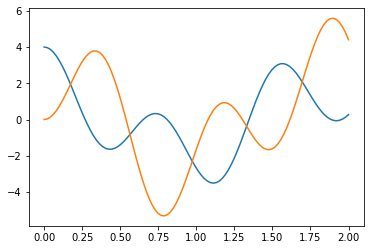

In [134]:
plt.plot(ts,out[:,0]*180/pi)
plt.plot(ts,out[:,1]*180/pi)
plt.show()

### Same equations are integrated using ode45 of octave for verification. 